# Wage growth

This category group contains real-time measures of wages or salary growth across many countries. Local conventions and importances of these data vary greatly across countries and the category group focuses on the most representative and commonly used local measures. Where more than one measure is widely watched, the growth rates of all of these are averaged into a single indicator.

Markets do not pay as much attention to wage data as they do to CPI or economic activity data. That reflects that they are published with greater delays and have less of a weight in the monetary policy decision making process. However, wage growth matters for the inflation outlook and for broad trends of corporate profitability in the economy.

**Ticker**: WAGES_NSA_P1M1ML12 / _P1M1ML12_3MMA / _P1M1ML12_6MMA / _P1Q1QL4 / _P1Q1QL4_2QMA

**Label**: Main local wage measure: %oya / %oya, 3mma / %oya, 6mma / %oya (q) / %oya, 2qma

**Definition**: Main measure of local wages, salaries or similar: % over a year ago / % over a year ago, 3-month moving average / % over a year ago, 6-month moving average / % over a year ago (quarterly) / % over a year ago 2-quarter moving average

**Notes**:

* Where available, monthly-frequency wages are used. Otherwise quarterly series are used. This is why there are monthly and quarterly transformation conventions.
* There is no common international standard for the higher-frequency wage data series that are mostly watched by the market. Wages levels and their volatility are not easily comparable.
* See [**Appendix 1**](#appendix1) for country-specific notes.

# Imports

Only the standard Python data science packages and the specialized `macrosynergy` package are needed.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import json
import yaml

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn


from macrosynergy.download import JPMaQSDownload

from timeit import default_timer as timer
from datetime import timedelta, date, datetime

import warnings

warnings.simplefilter("ignore")

The `JPMaQS` indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying *ticker strings*, formed by appending an indicator category code `<category>` to a currency area code `<cross_section>`. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where `<info>` denotes the time series of information for the given cross-section and category. The following types of information are available:

* `value` giving the latest available values for the indicator
* `eop_lag` referring to days elapsed since the end of the observation period
* `mop_lag` referring to the number of days elapsed since the mean observation period
* `grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded.

In [2]:
cids_dmca = [
    "AUD",
    "CAD",
    "CHF",
    "EUR",
    "GBP",
    "JPY",
    "NOK",
    "NZD",
    "SEK",
    "USD",
]  # DM currency areas
cids_dmec = ["DEM", "ESP", "FRF", "ITL", "NLG"]  # DM euro area countries
cids_latm = ["BRL", "COP", "CLP", "MXN", "PEN"]  # Latam countries
cids_emea = ["CZK", "HUF", "ILS", "PLN", "RON", "RUB", "TRY", "ZAR"]  # EMEA countries
cids_emas = [
    "CNY",
    "IDR",
    "INR",
    "KRW",
    "MYR",
    "PHP",
    "SGD",
    "THB",
    "TWD",
]  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [3]:
main = [
    "WAGES_NSA_P1M1ML12",
    "WAGES_NSA_P1M1ML12_3MMA",
    "WAGES_NSA_P1M1ML12_6MMA",
    "WAGES_NSA_P1Q1QL4",
    "WAGES_NSA_P1Q1QL4_2QMA",
]
econ = [
    "WFORCE_NSA_P1Y1YL1_5YMM",
    "RGDP_SA_P1Q1QL4_20QMM",
    "INFTARGET_NSA",
]  # economic context
mark = ["EQXR_NSA"]  # market links

xcats = main + econ + mark

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# Download from DataQuery

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as downloader:
    start = timer()
    df = downloader.download(
        tickers=tickers,
        start_date=start_date,
        metrics=["value", "eop_lag", "mop_lag", "grading"],
        suppress_warning=True,
        show_progress=True,
    )
    end = timer()

dfd = df

print("Download time from DQ: " + str(timedelta(seconds=end - start)))

Maximum number of tickers is 333


ValueError: Must provide either `client_id` and `client_secret` for oauth, or `crt`, `key`, `username`, and `password` for certificate based authentication.

# Availability

In [ ]:
cids_exp = sorted(list(set(cids)))  # cids expected in category panels
msm.missing_in_df(dfd, xcats=main, cids=cids_exp)

Missing xcats across df:  set()
Missing cids for WAGES_NSA_P1M1ML12:  {'ZAR', 'NOK', 'CHF', 'TRY', 'INR', 'AUD', 'IDR', 'EUR', 'SGD', 'ESP', 'FRF', 'NZD', 'CNY', 'PHP'}
Missing cids for WAGES_NSA_P1M1ML12_3MMA:  {'ZAR', 'NOK', 'CHF', 'TRY', 'INR', 'AUD', 'IDR', 'EUR', 'SGD', 'ESP', 'FRF', 'NZD', 'CNY', 'PHP'}
Missing cids for WAGES_NSA_P1M1ML12_6MMA:  {'ZAR', 'NOK', 'CHF', 'TRY', 'INR', 'AUD', 'IDR', 'EUR', 'SGD', 'ESP', 'FRF', 'NZD', 'CNY', 'PHP'}
Missing cids for WAGES_NSA_P1Q1QL4:  {'RUB', 'THB', 'MYR', 'SEK', 'TWD', 'CZK', 'GBP', 'RON', 'DEM', 'KRW', 'PLN', 'HUF', 'CAD', 'ILS', 'JPY', 'COP', 'USD', 'ITL', 'BRL', 'NLG', 'INR', 'CLP', 'PEN', 'MXN'}
Missing cids for WAGES_NSA_P1Q1QL4_2QMA:  {'RUB', 'THB', 'MYR', 'SEK', 'TWD', 'CZK', 'GBP', 'IDR', 'RON', 'DEM', 'KRW', 'PLN', 'HUF', 'CAD', 'ILS', 'JPY', 'COP', 'USD', 'ITL', 'BRL', 'NLG', 'INR', 'CLP', 'PEN', 'MXN'}


In [ ]:
# Renaming for graphs for ease of subsequent analysis


def rename(string):
    if string == "WAGES_NSA_P1M1ML12_3MMA":
        return "WAGES_POYA_3MMA"
    elif string == "WAGES_NSA_P1M1ML12_6MMA":
        return "WAGES_POYA_6MMA"
    elif string == "WAGES_NSA_P1Q1QL4_2QMA":
        return "WAGES_POYA_6MMA"
    elif string == "WAGES_NSA_P1Q1QL4":
        return "WAGES_POYA_3MMA"
    else:
        return string


dfd_rename = dfd.copy()
dfd_rename["xcat"] = dfd_rename["xcat"].apply(rename)

Available history of wage series is very uneven across countries. Even some developed countries' series only begin in the 2000s. Older "predecessor" series may, over time, be used to extend history.

For the explanation of currency symbols, which are related to currency areas or countries for which categories are available, please view [**Appendix 2**](#appendix2).

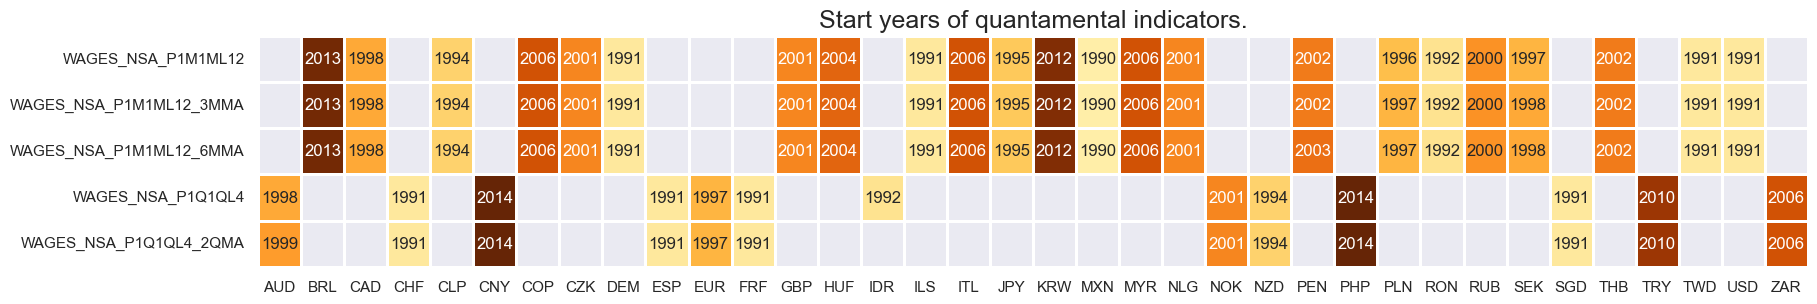

Last updated: 2023-07-14


In [ ]:
xcatx = main
cidx = cids_exp

dfx = msm.reduce_df(dfd, xcats=xcatx, cids=cidx)
dfs = msm.check_startyears(
    dfx,
)
msm.visual_paneldates(dfs, size=(20, 3))

print("Last updated:", date.today())

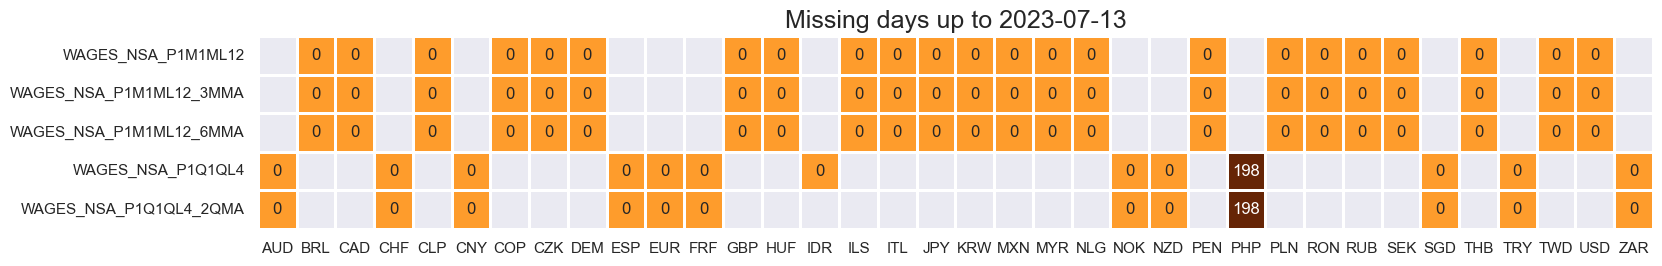

In [ ]:
plot = msm.check_availability(
    dfd, xcats=main, cids=cids_exp, start_size=(20, 2), start_years=False
)

Easily available top-grade vintages rarely go back far in history. 

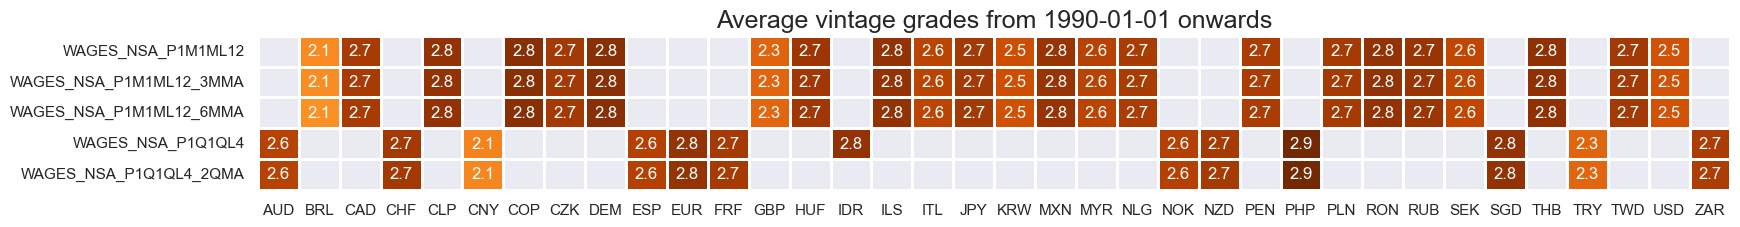

In [ ]:
plot = msp.heatmap_grades(
    dfd,
    xcats=main,
    cids=cids_exp,
    size=(19, 2),
    title=f"Average vintage grades from {start_date} onwards",
)

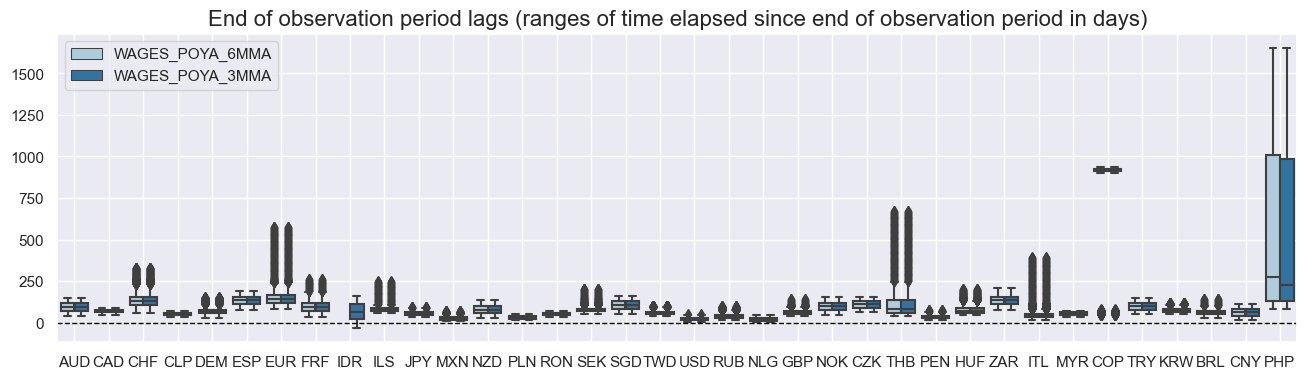

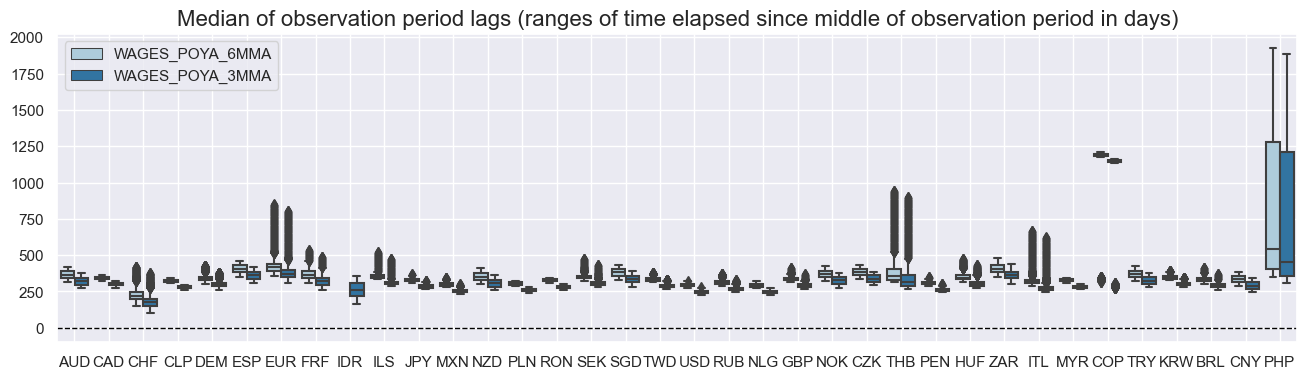

In [ ]:
msp.view_ranges(
    dfd_rename,
    xcats=["WAGES_POYA_6MMA", "WAGES_POYA_3MMA"],
    cids=cids_exp,
    val="eop_lag",
    title="End of observation period lags (ranges of time elapsed since end of observation period in days)",
    start="2000-01-01",
    kind="box",
    size=(16, 4),
)
msp.view_ranges(
    dfd_rename,
    xcats=["WAGES_POYA_6MMA", "WAGES_POYA_3MMA"],
    cids=cids_exp,
    val="mop_lag",
    title="Median of observation period lags (ranges of time elapsed since middle of observation period in days)",
    start="2000-01-01",
    kind="box",
    size=(16, 4),
)

# History

Wage growth rates and their standard deviations have been extremely uneven across countries. This reflects vast differences in both data quality and institutional background. It may not be easy to compare wage trends across countries in terms of their implication for monetary policy and competitiveness.

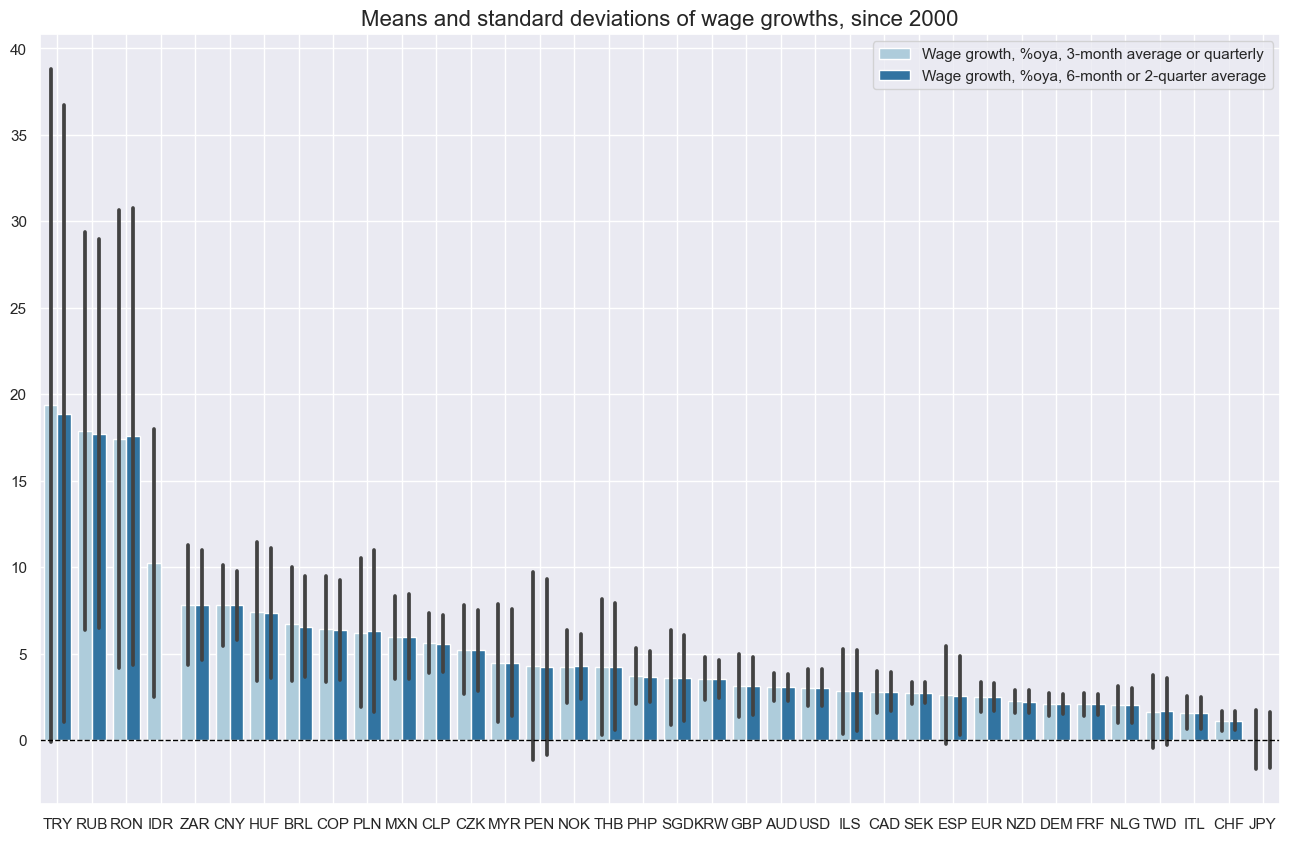

In [ ]:
xcatx = ["WAGES_POYA_3MMA", "WAGES_POYA_6MMA"]
cidx = cids_exp

msp.view_ranges(
    dfd_rename,
    xcats=xcatx,
    cids=cidx,
    title="Means and standard deviations of wage growths, since 2000",
    xcat_labels=[
        "Wage growth, %oya, 3-month average or quarterly",
        "Wage growth, %oya, 6-month or 2-quarter average",
    ],
    sort_cids_by="mean",
    start="2000-01-01",
    kind="bar",
    size=(16, 10),
)

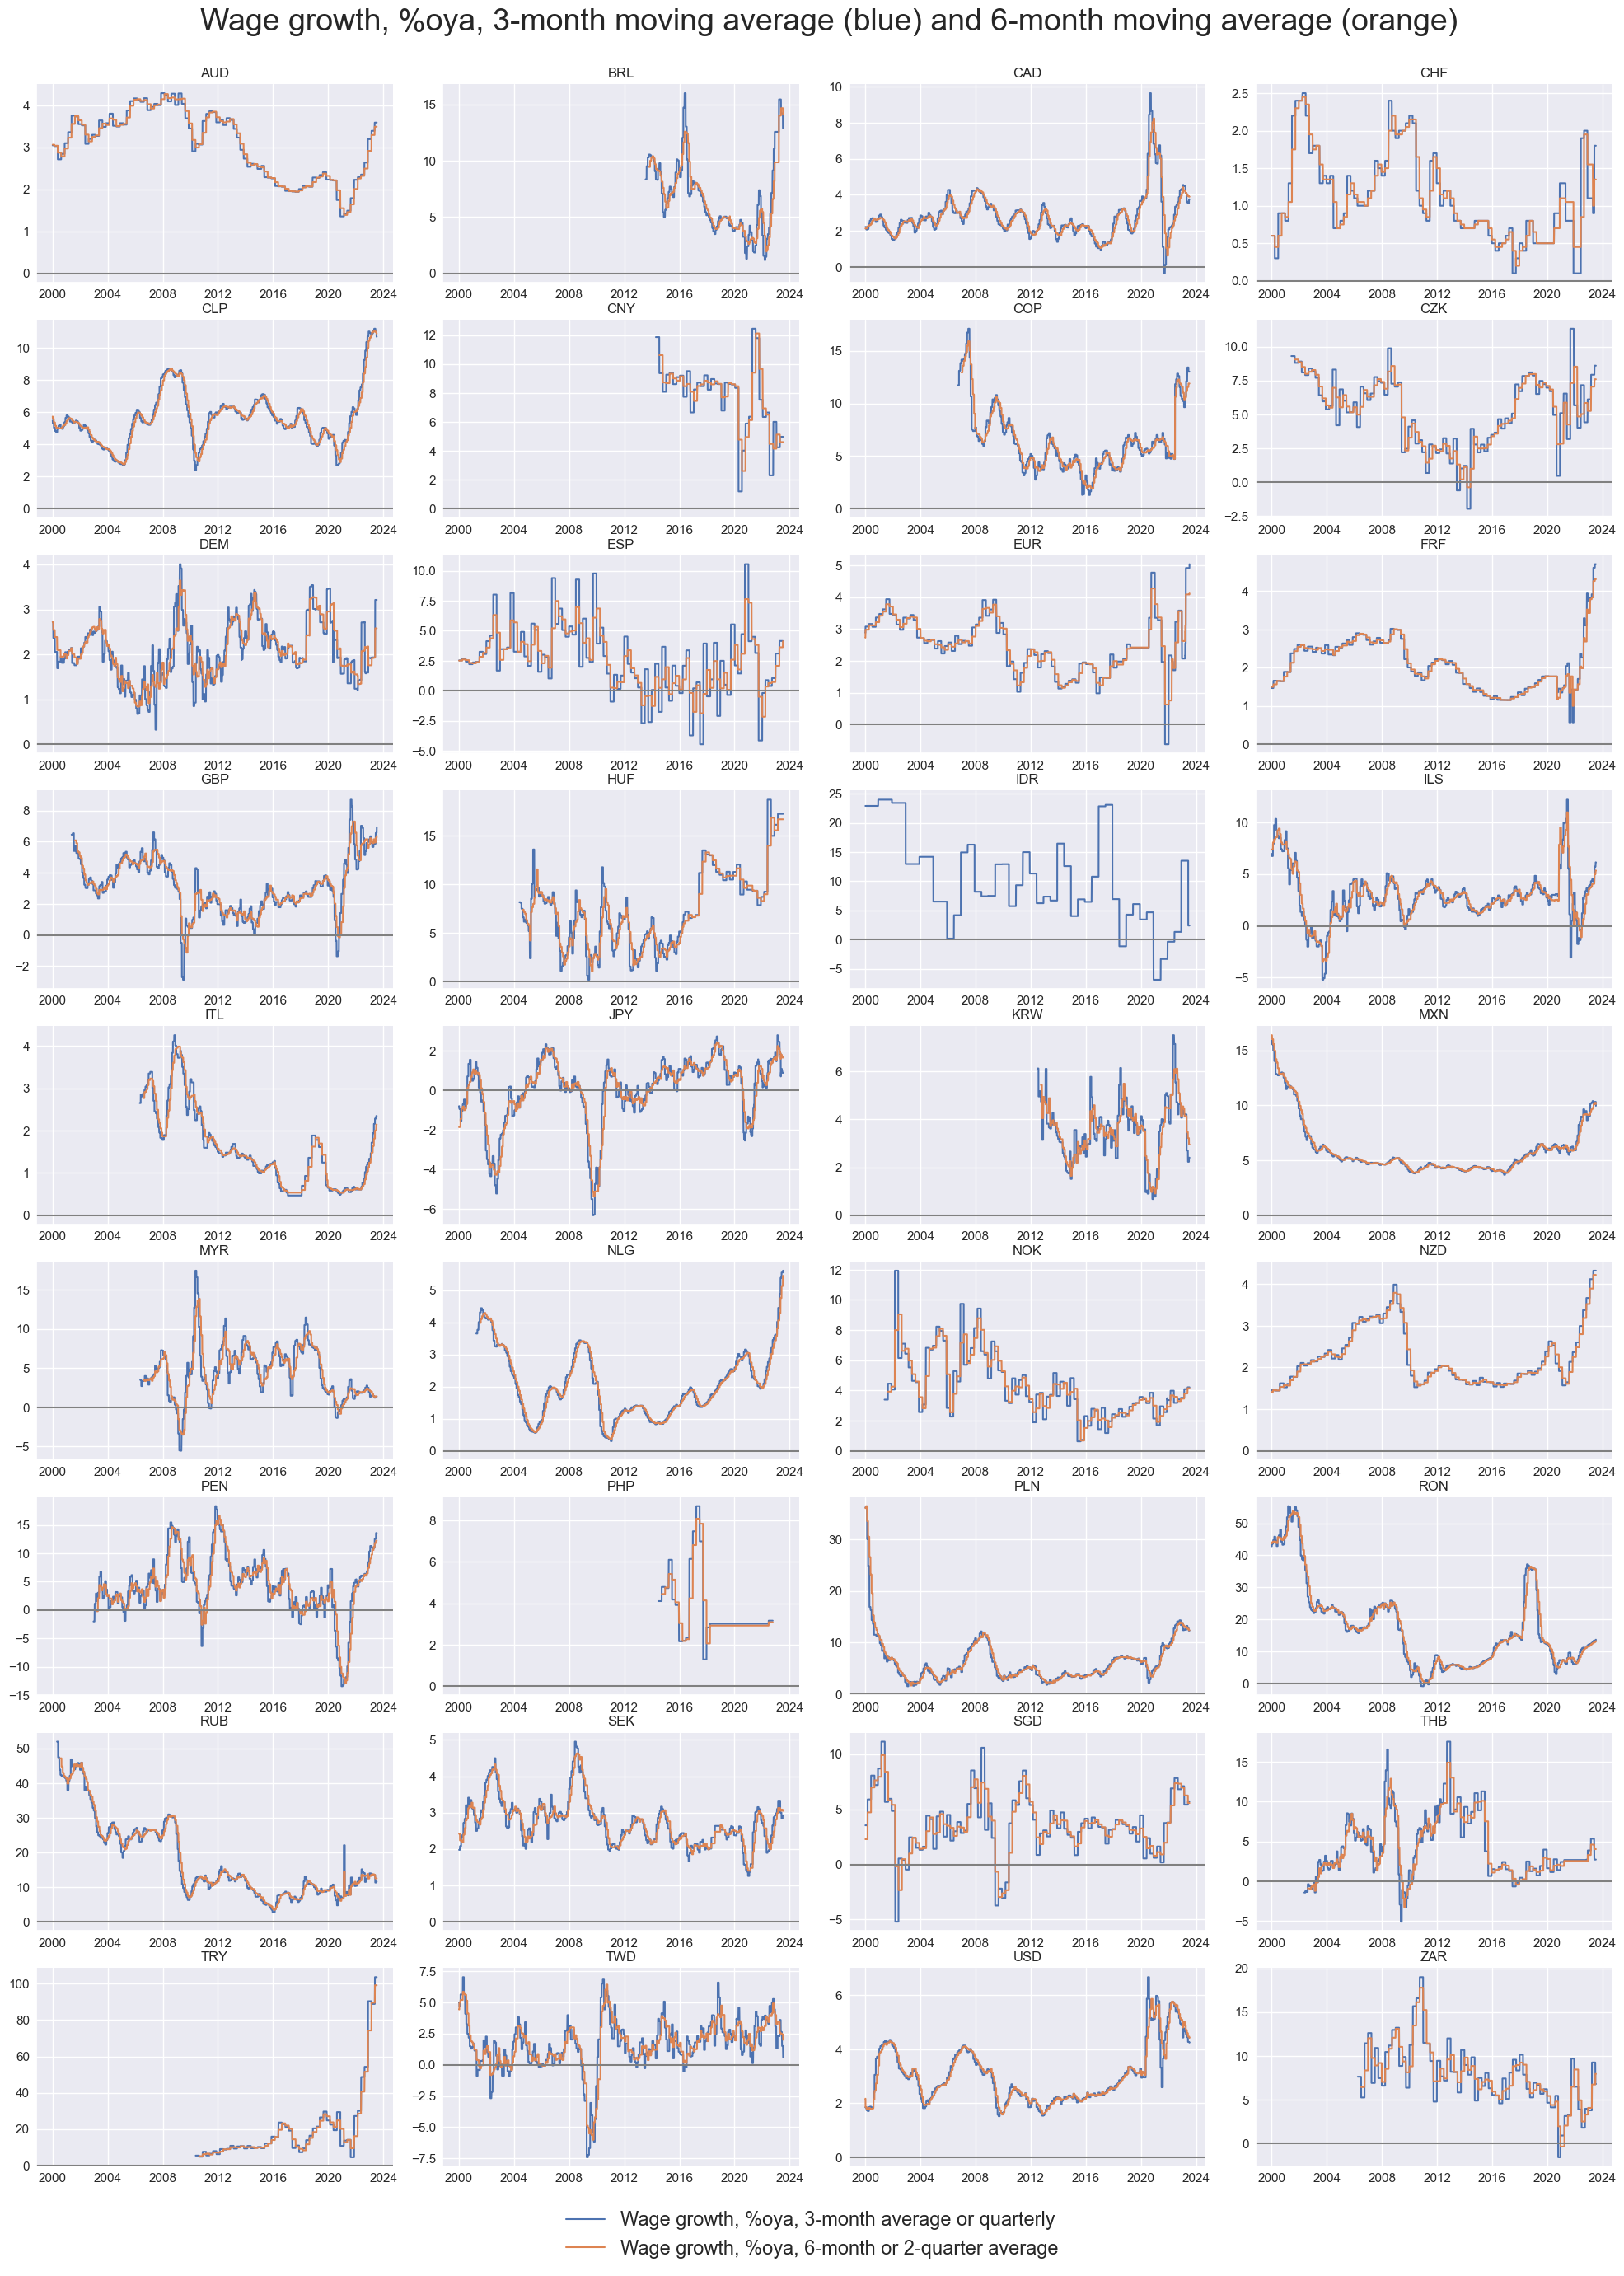

In [ ]:
xcatx = ["WAGES_POYA_3MMA", "WAGES_POYA_6MMA"]
cidx = cids_exp

msp.view_timelines(
    dfd_rename,
    xcats=xcatx,
    cids=cidx,
    xcat_labels=[
        "Wage growth, %oya, 3-month average or quarterly",
        "Wage growth, %oya, 6-month or 2-quarter average",
    ],
    start="2000-01-01",
    title="Wage growth, %oya, 3-month moving average (blue) and 6-month moving average (orange)",
    title_fontsize=27,
    legend_fontsize=17,
    title_adj=1.02,
    title_xadj=0.4,
    ncol=4,
    same_y=False,
    size=(20, 20),
    aspect=1.7,
    all_xticks=True,
)

Quantamental metrics of wage growth have not generally been strongly correlated across countries. 

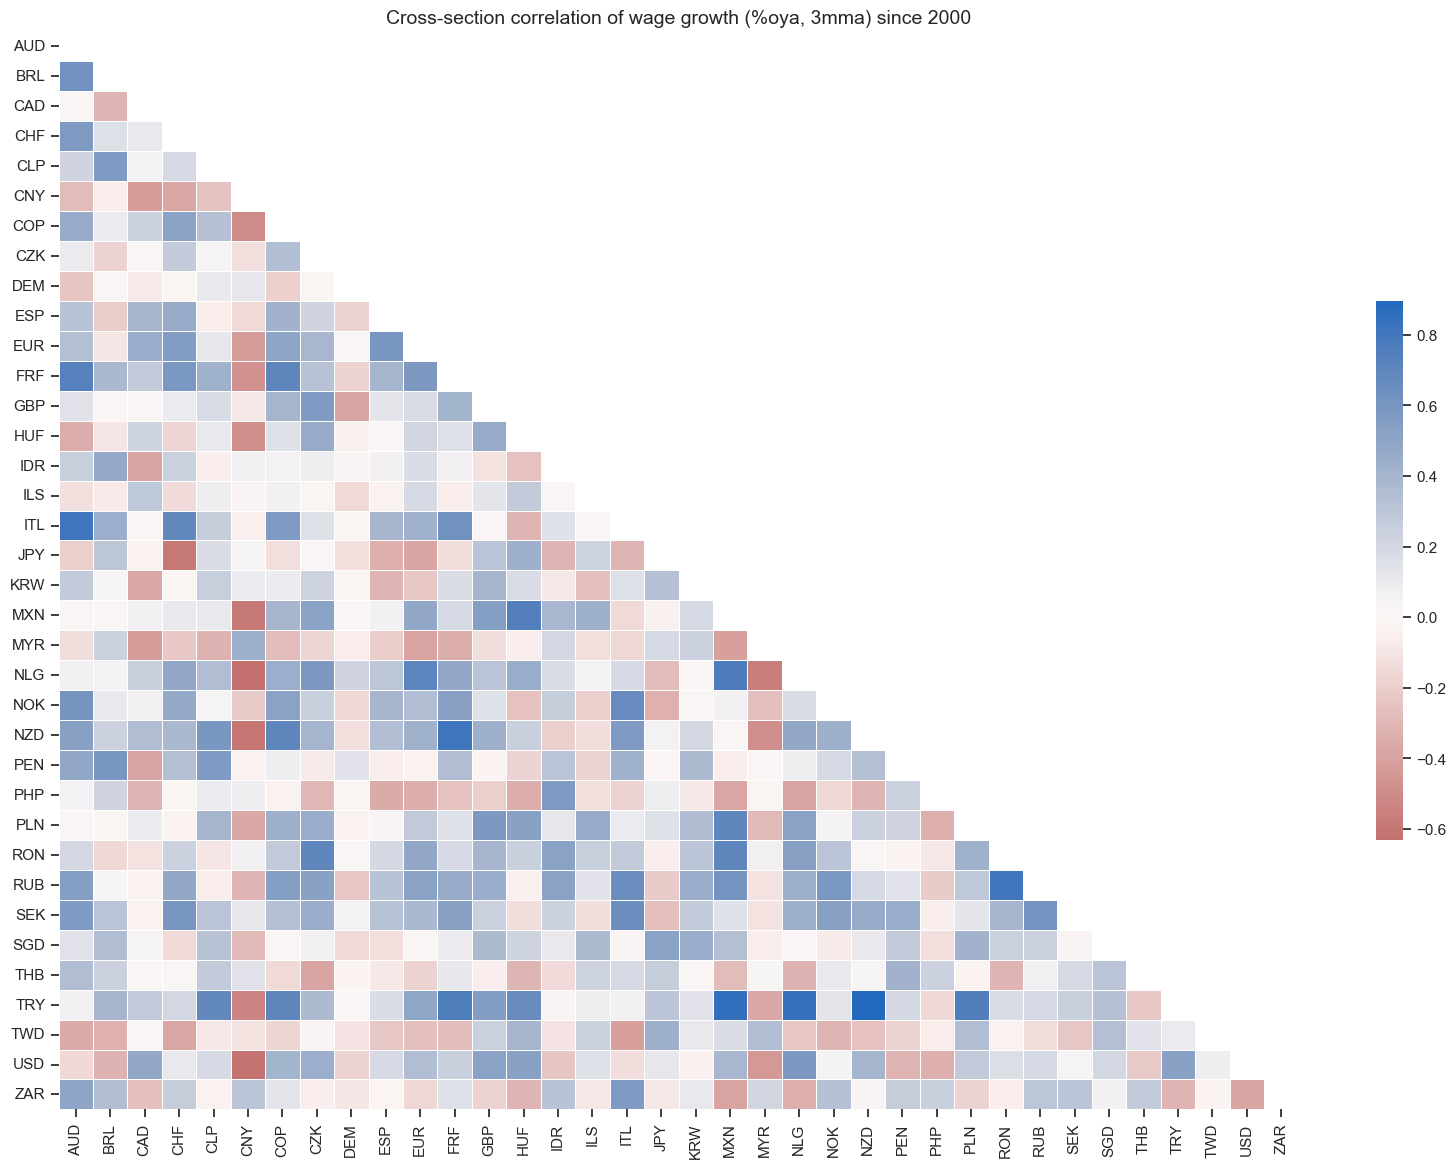

In [ ]:
cidx = list(set(cids_exp) - set(["INR"]))
msp.correl_matrix(
    dfd_rename,
    xcats="WAGES_POYA_3MMA",
    cids=cidx,
    title="Cross-section correlation of wage growth (%oya, 3mma) since 2000",
    size=(20, 14),
)

# Importance

## Research links

"On a quarterly basis, risk aversion shocks explain roughly 75% of variation in the log difference of stock market wealth, but the near permanent factors share shocks plays an increasingly important role as the time horizon extends. We find that more than 100% of the increase since 1980 in the deterministically detrended log real value of the stock market, or <u> a rise of 65% [in the stock market], is attributable to the cumulative effects of the factors share shock, which persistently redistributed rewards away from workers and toward shareholders over this period</u>." [Greenwald, Lettau, and Ludvigson](https://www.nber.org/system/files/working_papers/w19818/revisions/w19818.rev4.pdf)

## Empirical clues

Wage growth that is substantially above the central bank's inflation target should be a negative factor for equity returns because (a) it suggests a long-term reduction in profit margins and (b) it calls for tighter monetary policy. 

Indeed, there has been a negative correlation between real wage growth (nominal wage growth minus the inflation target) and equity index future returns since 2000. This is particularly seen amongst emerging markets.

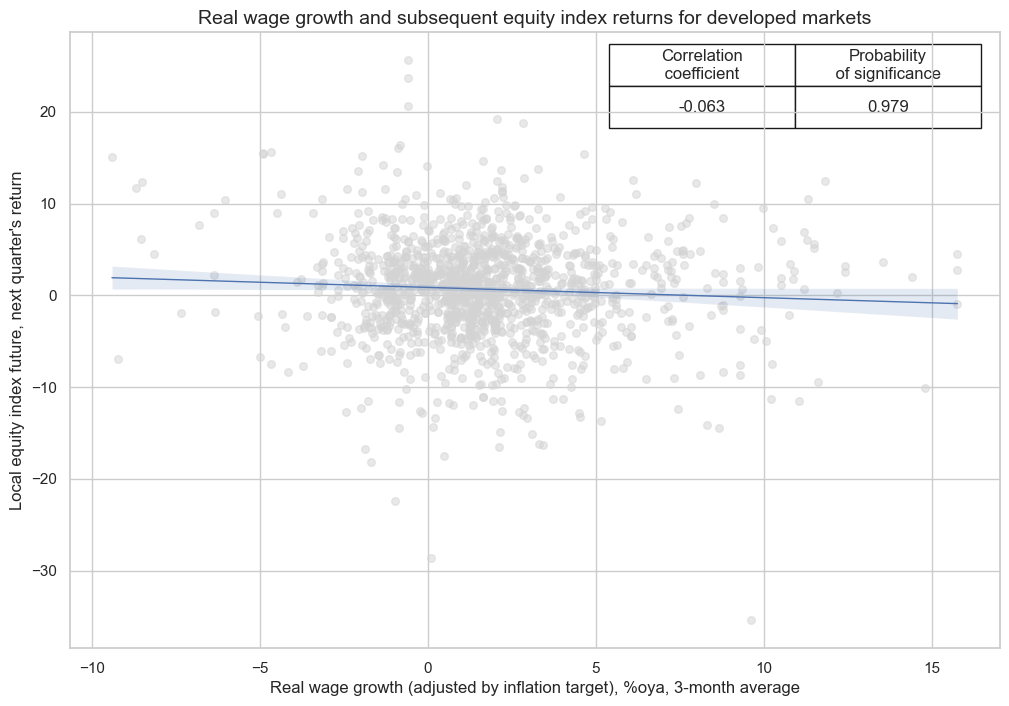

In [ ]:
dfx = dfd_rename

cidx = list(
    set(cids_em)
    - set(
        [
            "CLP",
            "CNY",
            "COP",
            "CZK",
            "HUF",
            "IDR",
            "ILS",
            "INR",
            "PEN",
            "PHP",
            "RON",
            "SGD",
            "TRY",
            "RUB",
            "ZAR",
        ]
    )
)  # remove missing cids

calcs = ["RWAGES_NSA_P1M1ML12_3MMA = WAGES_NSA_P1M1ML12_3MMA - INFTARGET_NSA"]
dfa = msp.panel_calculator(dfd, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

cr = msp.CategoryRelations(
    dfx,
    xcats=["RWAGES_NSA_P1M1ML12_3MMA", "EQXR_NSA"],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    fwin=1,
    start="2000-01-01",
)
cr.reg_scatter(
    title="Real wage growth and subsequent equity index returns for developed markets",
    labels=False,
    coef_box="upper right",
    xlab="Real wage growth (adjusted by inflation target), %oya, 3-month average",
    ylab="Local equity index future, next quarter's return",
)

In [ ]:
cr.ols_table()

                            OLS Regression Results                            
Dep. Variable:               EQXR_NSA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.336
Date:                Fri, 14 Jul 2023   Prob (F-statistic):             0.0210
Time:                        17:25:57   Log-Likelihood:                -4207.3
No. Observations:                1349   AIC:                             8419.
Df Residuals:                    1347   BIC:                             8429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# Appendices

## Appendix 1: Country-specific notes

<a id='appendix1'></a>
Further notes on wage data, for each cross-section are as below:
* AUD: In Australia, wages are post income tax and exclude bonuses.
* BRL: For Brazil, we use data on pre-tax wages from the main job.
* CAD: For Canada, we use a composite of hourly and weekly earnings growth. Both are after tax earnings and excluded agriculture.
* CLP: Chilean wage data are before income tax.
* CNY: China wages data are after income tax.
* COP: Colombian wage data are before income tax.
* CZK: Czech data encompass the following sectors: industry, market services, construction, and agriculture.
* DEM: For Germany, we use two wage series including bonuses and affter tax, from the Bundesbank and the statistics office.
* ESP: For Spain, we use salaries before taxes.
* FRF: For France, we use monthly non-farm average wages.
* EUR: For the euro area, we use a composite of OECD and eurostat data, both of which are after taxes.
* GBP: UK data are wages after taxes.
* HUF: Hungarian wage growth uses a composite of pre and post income tax wage data with and without tax benefits.
* ILS: For Israel, we use a composite of national bank and statistics office data.
* ITL: For Italy, we use wages including bonuses and before taxes.
* JPY: Japan wage data before taxes and a composite of cabinet office and statistics office data.
* KRW: In order to account for the impact of the lunar new year on South Korea (bonus payments), January and Feburary observations are combined and assigned to the release date for February.
* MXN: In Mexico, wage data are after taxes and exclude bonuses and growth is composite based on contractual wages and daily earnings.
* NLG: For the Netherlands, we use two wage series, one with and one without bonuses.
* NOK: For Norway, data are before income tax exclude bonuses. Also, prior to 2016 the series is based on manufacturing wages, rather than economy-wide wages.
* NZD: For New Zealand, we use a salary and wage index that excludes performance-based pay and is after income tax.
* PEN: For Peru, we actually use a time series of average income in Lima.
* PHP: The Philipines stopped reporting wage data in 2018.
* PLN: For Poland, we use average monthly wages before taxes.
* RON: For Romania, we use an average monthly wage series that includes bonuses and is before taxes.
* RUB: For Russia, the series measures average monthly wages, includes bonuses and is before taxes.
* SEK: For Sweden, we use average monthly wages and salaries combining data of the national mediation office and and the statistics office.
* SGD: For Singapore, we refer to average monthly income after taxes.
* THB: The Thai wage growth series is based on a composite of average wages as published by the national bank and the statistics office.
* TRY: For Turkey, we use total hourly earnings before taxes.
* TWD: For Taiwan, we look at average monthly earnings including bonuses and after taxes. In order to account for the impact of the lunar new year on Taiwan (bonus payments), January and Feburary observartions are combined and assigned to the release date for February.
* USD: The U.S. wage growth series is based on an average of average weekly and hourly earnings and refers only to private employees.
* ZAR: For South Africa, we use average monthly earnings after taxes and including bonuses.

## Appendix 2: Currency symbols

<a id='appendix2'></a>
The word 'cross-section' refers to currencies, currency areas or economic areas. In alphabetical order, these are
AUD (Australian dollar), BRL (Brazilian real), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), CNY (Chinese yuan renminbi), COP (Colombian peso), CZK (Czech Republic koruna), DEM (German mark), ESP (Spanish peseta), EUR (Euro), FRF (French franc), GBP (British pound), HKD (Hong Kong dollar), HUF (Hungarian forint), IDR (Indonesian rupiah), ITL (Italian lira), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), MYR (Malaysian ringgit), NLG (Dutch guilder), NOK (Norwegian krone), NZD (New Zealand dollar), PEN (Peruvian sol), PHP (Phillipine peso), PLN (Polish zloty), RON (Romanian leu), RUB (Russian ruble), SEK (Swedish krona), SGD (Singaporean dollar), THB (Thai baht), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar), ZAR (South African rand).